# Attempting to measure the discrete performance of volatility indexs
This notebook will look at how to quantify the effectiveness of a calculated index for any point in time. As these indexs are forward looking the performance of a security over the year following the date of observation will be taken.

In [38]:
%load_ext autoreload
%autoreload 2

import metrics_calc
import vix_calc, vix_calc_other
import sqlite3
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
conn = sqlite3.connect("../data_aggregation/flow_database.db")
conn.row_factory = vix_calc.my_row_factory
cursor = conn.cursor()

In [45]:
DT = '2022-01-07'

d = datetime.strptime(DT, '%Y-%m-%d')
# (d + timedelta(days=365)).strftime('%Y-%m-%d')

In [50]:
def query_spy(DT):
    d = datetime.strptime(DT, '%Y-%m-%d')
    for_dt = (d + timedelta(days=365)).strftime('%Y-%m-%d')
    query = f"""
    select
        open,
        close,
        date_of,
        date_of_close
    from price_data

    where symbol = 'SPY'
    and date_of_close >= '{DT}'
    and date_of_close <= '{for_dt}'
    ;
    """

    cursor.execute(query)
    data = cursor.fetchall()
    data = pd.DataFrame.from_records(data)
    
    data['date_of_close'] = data.date_of_close.apply(pd.to_datetime)
    data['annual_'] = (data.date_of_close - d).dt.days / 365
    
    return data

def observe_vix_acc(DT):
    VIX = vix_calc.main(DT)
    data = query_spy(DT)
    start_close = data.iloc[0].close
    
    data['vix_t'] = data.annual_.apply(lambda x: vix_calc.get_period_volatility(VIX, x))
    
    data['price_up'] = (data.vix_t / 100 + 1) * start_close
    data['price_down'] = (-data.vix_t / 100 + 1) * start_close
    return (data, VIX)

def observe_vix_acc_o(DT):
    VIX = vix_calc_other.main(DT)
    data = query_spy(DT)
    start_close = data.iloc[0].close
    
    data['vix_t'] = data.annual_.apply(lambda x: vix_calc.get_period_volatility(VIX, x))
    
    data['price_up'] = (data.vix_t / 100 + 1) * start_close
    data['price_down'] = (-data.vix_t / 100 + 1) * start_close
    return (data, VIX)

In [51]:
data, vix = observe_vix_acc(DT)
data.head(4)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down
0,476.30,466.09,2022-01-03,2022-01-07,0.000000,0.000000,466.090000,466.090000
1,462.70,464.72,2022-01-10,2022-01-14,0.019178,2.508360,477.781216,454.398784
2,459.74,437.98,2022-01-17,2022-01-21,0.038356,3.547357,482.623876,449.556124
3,432.03,441.95,2022-01-24,2022-01-28,0.057534,4.344607,486.339780,445.840220


In [52]:
data.vix_t.sum()

635.6140259444494

## A look at implied volatilty as prescribed by the vix over a period of time

18.11287154256035


<AxesSubplot: xlabel='date_of_close'>

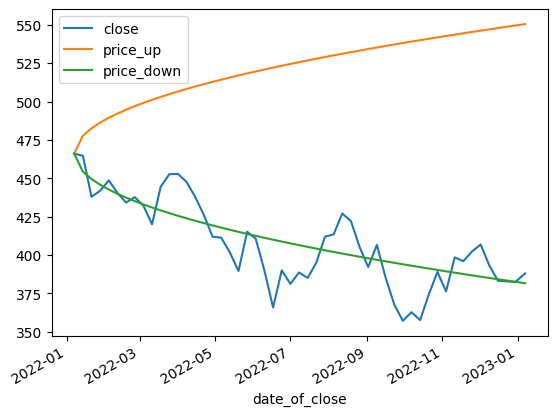

In [53]:
data, VIX = observe_vix_acc(DT)
print(VIX)
data.plot(x='date_of_close', y=['close', 'price_up', 'price_down'])

0.001166194645537143 0.0009600344135350957
0.0022137990774731015 0.0016722807121791
27.40247844774618


<AxesSubplot: xlabel='date_of_close'>

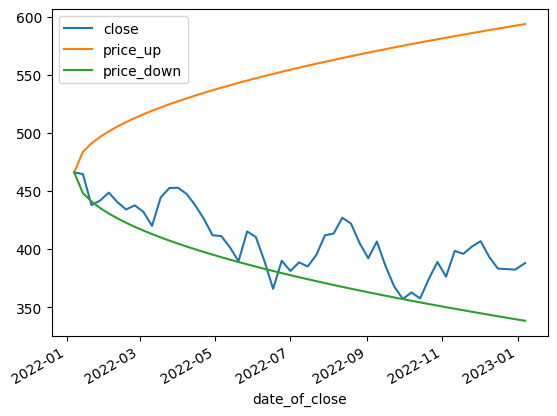

In [54]:
data, VIX = observe_vix_acc_o(DT)
print(VIX)
data.plot(x='date_of_close', y=['close', 'price_up', 'price_down'])

## A look at the absolute change in the SPY (to date), and the prescribed volatility bound

In [16]:
data.head(3)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_init
0,381.81,389.99,2023-03-13,2023-03-17,0.000000,0.000000,389.990000,389.990000,0.000000
1,390.80,395.75,2023-03-20,2023-03-24,0.019178,3.485596,403.583477,376.396523,1.476961
2,398.12,409.39,2023-03-27,2023-03-31,0.038356,4.929378,409.214079,370.765921,4.974487


In [11]:
vix * 2/3

16.77966306350971

In [21]:
((data.iloc[:52].vix_t).sum() / 16.77966306350971) / 12

0.5687327029056853

In [22]:
(data.iloc[:53].vix_t).sum()

114.51771753547882

Text(0, 0.5, 'Absolute change since first period')

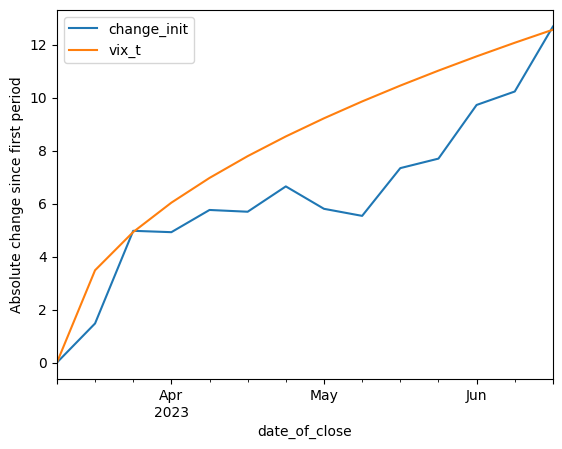

In [23]:
data['change_init'] = abs(data.close / data.close.iloc[0] - 1) * 100
ax = data.plot(x='date_of_close', y=['change_init', 'vix_t'])
ax.set_ylabel('Absolute change since first period')

## 3 ways of measuring effectiveness for a individual period
1. Count how frequently the SPY leaves the vix bounds
3. Compare Index to the standard deviation of the stocks proven performance
2. Take the difference between the area under the curve for both indexs.

#### Simple Accuracy

In [25]:
df = data[['close', 'date_of_close', 'vix_t', 'change_init']].copy()

# within, exceeded = df.bounded.value_counts().loc[True], df.bounded.value_counts().loc[False]
within, exceeded = metrics_calc.calc_accuracy(df, real_col='change_init')
print('Within Bound:\t', within)
print('Exceeded bound:\t', exceeded)
print('Accuracy: ', round(within/(within+exceeded)*100, 2))

Within Bound:	 12
Exceeded bound:	 2
Accuracy:  85.71


#### Standard Deviation
Note: As the standard deviation is an annualised value, for any given point, the difference between the VIX and the STD for the following year can be compared.

In [26]:
df.close.std()

12.762550147354412

In [27]:
print('Standard Deviation:\t\t', df.close.std())
print('Relative Standard Deviation:\t', df.close.std() / df.close.mean() * 100)

Standard Deviation:		 12.762550147354412
Relative Standard Deviation:	 3.0779356261007527


## Area Under the curve

In [28]:
df.change_init.std()

3.2725326668259185

In [29]:
data.vix_t.sum() - data.change_init.sum()

26.0051915732747

In [30]:
data['curve_diff'] = data.vix_t - data.change_init

In [33]:
metrics_calc.calc_auc_aoc(data, curveA='change_init', curveB='vix_t')

(26.167745119747632, -0.16255354647292908)

In [37]:
data.vix_t.sum()

114.51771753547882

In [34]:
data[data.curve_diff > 0].curve_diff.sum()

26.167745119747632

In [35]:
data.head()

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_init,curve_diff
0,381.81,389.99,2023-03-13,2023-03-17,0.000000,0.000000,389.990000,389.990000,0.000000,0.000000
1,390.80,395.75,2023-03-20,2023-03-24,0.019178,3.485596,403.583477,376.396523,1.476961,2.008635
2,398.12,409.39,2023-03-27,2023-03-31,0.038356,4.929378,409.214079,370.765921,4.974487,-0.045109
3,408.85,409.19,2023-04-03,2023-04-07,0.057534,6.037230,413.534593,366.445407,4.923203,1.114027
4,406.61,412.46,2023-04-10,2023-04-14,0.076712,6.971193,417.176954,362.803046,5.761686,1.209506
